<a href="https://colab.research.google.com/github/eagomez2/mir_basics/blob/main/eagomez_assignment01_exemplary_mir_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIR assignment 01 - Basic flow in an exemplary MIR classification research task 

## Instructions
In this assignment you should understand and reproduce the instrument classification experiment presented in [this jupyter notebook](https://github.com/MTG/MIRCourse/blob/master/notebooks/Lecture1_IntroWithACaseStudy.ipynb), and then adapt the notebook to another instrument classification task, one using the [Mridangam Stroke dataset](https://zenodo.org/record/4068196). The goal is to automatically recognize the 10 different stroke classes or the 6 different tonic classes present in the dataset (you choose), trying to obtain the best possible accuracy. For both tasks you should use the whole dataset.  

The goal of the assignment is to understand and be able to implement all the steps involved in a typical audio-based classification problem. Thus, understanding all the steps involved in designing the experiment and making the best choices for a given task. You should briefly explain within the submitted notebook, all the decisions taken in every step of the experiment.  

You can optionally add a step of feature selection. Feature selection is the removal of redundancies in features, lowering the dimensionality of the feature space. Effective feature selection can improve performance of a classifier and would lower memory and computation requirements.

- Increase the number of classes to 8 (either use more classes from UIOWA:MIS dataset or continue with the Mridangam dataset)

- Add a feature selection step in the process (most critical part)

- Observe and report its contribution, discuss your observations

## About the structure of this notebook

The author has chosen to implement the necessary code for the following tasks:
1. Tonic classification of the Mridangam Stroke dataset
2. Stroke classification of the Mridangam Stroke dataset

Additionally, some techniques for **feature selection** and **class imbalance** are addressed to evaluate their impact in the aforementioned tasks.

# Installing Essentia  
Essentia is an open-source library and tools for audio and music analysis, description and synthesis whose documentation can be found [here](https://essentia.upf.edu/).

In [1]:
# Installs Essentia if it's not installed yet
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia

     |████████████████████████████████| 12.0MB 263kB/s 


# Imports  
Some other dependencies that are going to be used for the different sections of this notebook.

In [2]:
import os, sys, shutil, zipfile, requests, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import essentia.standard as ess
import seaborn as sns
from tqdm.notebook import tqdm # helps to create progress bars during loops
from pathlib import Path
from IPython.display import display, Markdown

# Dataset acquisition  
The code in the following sections downloads and uncompresses the Mridangam Stroke dataset, locating it inside the corresponding folder for reading and further processing of the audio files.  

The dataset is comprised of 6 tonic classes and 10 stroke classes named under the following conventions:

> StrokeName_Tonic_InstanceNumber.wav  
> Tonic = {B, C, Csh, D, Dsh, E}  
> StrokeName = {Bheem, Cha, Dheem, Dhin, Num, Ta, Tha, Tham, Thi, Thom}

Additional description about the dataset can be found [here](https://zenodo.org/record/4068196#.YBINk3dKjQg).

## Download helper function  
The following function is created in order to download the dataset appropriately.

In [3]:
def download_content(url=None, filename=None, dir='data', chunk_size=1024, unzip=False, delete_original=False, delete_postflight=[]):
  """ Downloads the dataset to a local folder, unzip it and get rids of
      unnecessary content if necessary.

      Args:
          url (str):                Link of the downloadable dataset.
          filename (str):           Name to be given to the dataset file.
          dir (str):                Folder where the dataset is stored.
          chunk_size (int):         Chunk size for the download streaming.
          unzip (bool):             Unzip after download is completed.
          delete_original (bool):   If True, deletes original file after it is uncompressed.
          delete_postflight (list): List of strings containing folders to be deleted after
              the file is downloaded and unziped.
  """
  r = requests.get(url, stream=True)

  try:
    total_size = int(r.headers['content-length'])
  except:
    total_size = chunk_size    # Content-length may be unknown if the source will only stream the file

  filepath = os.path.join(dir, filename)

  # Make folder if it does not exist
  if not os.path.exists(dir):
    os.mkdir(dir)

  # Download the content
  with open(filepath, 'wb') as file:
    for data in tqdm(iterable=r.iter_content(chunk_size=chunk_size), total=(total_size / chunk_size), unit='MB'):
      file.write(data)
    
  print(f'Content successfully downloaded to {filepath}')

  # Unzip file
  if unzip:
    print(f'Uncompressing {filename}...')
    zip_extractor = zipfile.ZipFile(filepath, 'r')
    zip_extractor.extractall(dir)
    zip_extractor.close()
    print(f'Uncompressed file saved to {dir}...')

  # Delete original folder
  if delete_original:
    print(f'Deleting original file {filepath}...')
    os.remove(filepath)

  # Delete other unnecessary folders
  if delete_postflight:
    for item in delete_postflight:
      item_path = os.path.join(dir, item)
      if os.path.exists(item_path):
        print(f'Deleting unnecessary item {item_path}')
        shutil.rmtree(item_path)

  print('Operation completed!')

## Dataset related definitions  
Some dataset related constants are stored to be used in later steps.

In [4]:
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATA_ROOT = os.path.join(BASE_DIR, 'data')
DATASET_URL = 'https://zenodo.org/record/4068196/files/mridangam_stroke_1.5.zip'
DATASET_NAME = os.path.splitext(os.path.basename(DATASET_URL))[0]
DATASET_ROOT = os.path.join(DATA_ROOT, DATASET_NAME)
DATASET_FS = 44100

# If true, data.csv will be obtained and therefore feature extraction
# with Essentia will not be re-computed to save some time executing this notebook.
# The dataset will still be downloaded to visualize the files.
DOWNLOAD_PRECOMPUTED_DATA = True
PRECOMPUTED_DATA_URL = 'https://drive.google.com/file/d/1oT62rh-VOxWq5dGr6W2O5vC6t77Kl2R3/view?usp=sharing'

# A dict to pattern match file names
TONIC_CLASSES = {
    '-b-':    'b',
    '-c-':    'c',
    '-csh-':  'c#',
    '-d-':    'd',
    '-dsh-':  'd#',
    '-e-':    'e',
}

STROKE_CLASSES = {
    '_bheem-':  'bheem',
    '_cha-':    'cha',
    '_dheem-':  'dheem',
    '_dhin-':   'dhin',
    '_num-':    'num',
    '_ta-':     'ta',
    '_tha-':    'tha',
    '_tham-':   'tham',
    '_thi-':    'thi',
    '_thom-':   'thom',
}

## Download the dataset  
Downloads and uncompresses the dataset at the given location. If `DOWNLOAD_PRECOMPUTED_DATA` is set to `True` in the previous cell, the file containing precomputed Essentia features will be downloaded in order to save time. In either case, the dataset will still be downloaded to compute visualizations of its content.

In [5]:
download_content(url=DATASET_URL, 
                 filename=DATASET_URL.split('/')[-1], 
                 dir=DATA_ROOT,
                 unzip=True,
                 delete_original=True,
                 delete_postflight=['__MACOSX'])

if DOWNLOAD_PRECOMPUTED_DATA:
    download_content(url=PRECOMPUTED_DATA_URL, 
                     filename='data.csv', 
                     dir=DATASET_ROOT)


Content successfully downloaded to /content/data/mridangam_stroke_1.5.zip
Uncompressing mridangam_stroke_1.5.zip...
Uncompressed file saved to /content/data...
Deleting original file /content/data/mridangam_stroke_1.5.zip...
Deleting unnecessary item /content/data/__MACOSX
Operation completed!



Content successfully downloaded to /content/data/mridangam_stroke_1.5/data.csv
Operation completed!


# Collecting information from the dataset  
Some useful information for the `tonic_class` and `stroke_class` classification tasks is extracted.

## Path mapping helper function  
This function will help to match patterns in the filepath to a key from a given `dict`, allowing to exploit dataset naming conventions to classify the data.

In [6]:
def map_path_substr(path, substr_map, default=np.NaN, use_filename=True):
    """ Maps a pattern matched in path to a key found in substr_map.

    Args:
        path (str):          The path of a file (or folder).
        substr_map (dict):   Dictionary containing key/value pairs for mapping.
        default:             Default value given to unmapped items.
        use_filename (bool): Use filename only and ignore directory.
        
    Returns:
        mapped_val (str): Mapped value obtained from the substr_map.
    """
    mapped_val = default

    if use_filename: path = Path(path).stem

    for key in substr_map.keys():
        if key in path: mapped_val = substr_map[key]

    return mapped_val

## DataFrame display helper function 
This very short function will help to visualize full-width columns when displaying `pd.DataFrames`.

In [8]:
def display_fullwidth(df):
    """ Display fullwidth DataFrame. 
    Args:
        df (pd.DataFrame): DataFrame to be displayed.
    """
    pd.set_option('display.max_colwidth', None)
    display(df)
    pd.reset_option('display.max_colwidth')

## Parsing dataset file structure  
The filenames from the dataset are matched against some patterns to label their `tonic_class` and `stroke_class`. All this information is then stored in a `pd.DataFrame` object.

In [9]:
audiofiles = [os.path.join(root, file) 
              for root, dirs, files in os.walk(DATASET_ROOT) 
              for file in files if file.endswith('.wav')]

df_audiofiles = pd.DataFrame(audiofiles, columns=['filepath'])
df_audiofiles['tonic_class'] = df_audiofiles['filepath'].map(lambda filepath: map_path_substr(filepath, TONIC_CLASSES))
df_audiofiles['stroke_class'] = df_audiofiles['filepath'].map(lambda filepath: map_path_substr(filepath, STROKE_CLASSES))

display_fullwidth(df_audiofiles)

,filepath,tonic_class,stroke_class
0,/content/data/mridangam_stroke_1.5/B/224989__akshaylaya__thi-b-208.wav,b,thi
1,/content/data/mridangam_stroke_1.5/B/224879__akshaylaya__thi-b-098.wav,b,thi
2,/content/data/mridangam_stroke_1.5/B/224030__akshaylaya__bheem-b-001.wav,b,bheem
3,/content/data/mridangam_stroke_1.5/B/225348__akshaylaya__thom-b-129.wav,b,thom
4,/content/data/mridangam_stroke_1.5/B/224451__akshaylaya__ta-b-103.wav,b,ta
...,...,...,...
6972,/content/data/mridangam_stroke_1.5/D/227900__akshaylaya__ta-d-105.wav,d,ta
6973,/content/data/mridangam_stroke_1.5/D/228007__akshaylaya__tha-d-032.wav,d,tha
6974,/content/data/mridangam_stroke_1.5/D/228295__akshaylaya__thi-d-067.wav,d,thi
6975,/content/data/mridangam_stroke_1.5/D/227795__akshaylaya__num-d-018.wav,d,num


## Investigating and preprocessing raw data  
In the following cell, one sample is taken for each pitch class in order to get an idea about how our data looks like.

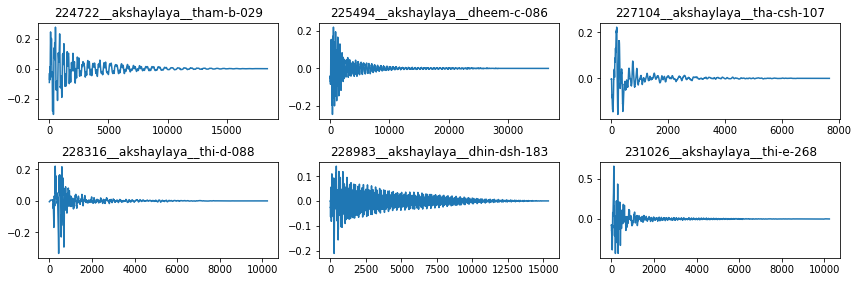

In [12]:
# Sample some files to plot (one for each tonic class)
df_sample = df_audiofiles.groupby('tonic_class')['filepath'] \
                         .apply(lambda group: group.sample(n=1, random_state=1))

# plot each sample
plt.figure(figsize=(2 * len(TONIC_CLASSES), 4))

for idx, sample_file in enumerate(df_sample):
    x = ess.MonoLoader(filename=sample_file, sampleRate=DATASET_FS)()

    plt.subplot(2, 3, (idx + 1))
    plt.plot(x)
    plt.tight_layout(pad=1.0)
    plt.title(Path(sample_file).stem)

As it is observed, all files contain a single stroke and therefore there is no need to segment data as it may occur in other datasets where several audio chunks that are supposed to be analyzed separately are grouped in a single file.